In [554]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np

In [555]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
            num_words=10000)

In [825]:
ls ..

Build_a_Large_Language_Model_(From_Scrat.pdf
Deep_Learning_with_Python.pdf
Deep_Learning_with_Python_Second_Editio.pdf
FinalProjectIdeasFinal.pdf
Untitled.ipynb
crypto_apps.csv
gptopic/
literature/


## Decoding news wires back to text

In [557]:
word_index = reuters.get_word_index()

In [558]:
label_names = reuters.get_label_names()

In [559]:
reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()]) 

In [560]:
def decode_text(text, reverse_word_index):
    decoded_text = " ".join(
                [reverse_word_index.get(i - 3, "?") for i in text])
    return decoded_text

In [561]:
decode_text(train_data[2], reverse_word_index)

'? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one split effective january 6 1987 per share amounts are calculated after preferred stock dividends loss continuing operations for the qtr 1986 includes gains of sale of investments in ? corp of 14 mln dlrs and associated companies of 4 189 000 less writedowns of investments in national ? inc of 11 8 mln and ? corp of 15 6 mln reuter 3'

## Sample texts

In [562]:
import random


In [569]:
random.seed(42)
sample_index  = random.sample(range(1, len(train_data)), 2000)

In [570]:
text_sample = train_data[sample_index]
labels_sample = train_labels[sample_index]

In [571]:
label_names_sample = [label_names[label] for label in labels_sample]

In [572]:
decoded_text_sample = [decode_text(text, reverse_word_index) for text in text_sample]

In [573]:
df = pd.DataFrame({"text": decoded_text_sample, "label_code": labels_sample, "label_name": label_names_sample})

In [574]:
#df.to_csv("newsweek_sample_2000.csv", index=False)

In [575]:
df = pd.read_csv("newsweek_sample_150.csv")

In [576]:
df.shape

(150, 3)

## Extracting topics with a local LLM

In [585]:
#!pip install ollama
#ref: https://github.com/ollama/ollama
#run in terminal: ollama run llama3.2:1b
import ollama
import google.generativeai as genai

Usar el texto 2 de la muestra para mostrar la inestabilidad del resultado.

In [578]:
prompt_v1 = "You are an expert news anchor. What news category does this article belong to?: {text}"
prompt_v2 = "You are an expert news anchor. What news category does this article belong to? Provide your best guess: {text}"
prompt_v3 = "You are an expert news anchor. What news category does this article belong to? \
    Provide your best guess in a sentence with no more than 4 words: {text}"
prompt_v4 = "You are an expert news anchor. What news category does the following article belong to? \
    Please answer only with the category. If you are unsure, your best guess is ok: {text}"

prompt_v5 = "You are an expert news anchor. What news category does the following article belong to? \
    Please answer only with one category.\
    If you are unsure, your best guess is ok. Do not include question marks: {text}"

In [610]:
def ollama_query(text, prompt):
    prompt = prompt
    

    response = ollama.chat(
        model = "llama3.2:1b",
        messages = [{"role":"user", "content":prompt.format(text=text)}]    
    )

    return response["message"]["content"].strip()

In [611]:
def gemini_query(text, prompt):
    prompt = prompt
    genai.configure(api_key=)
    model = genai.GenerativeModel("gemini-1.5-flash-latest")
    try:
        response = model.generate_content(prompt.format(text=text))
    except:
        response = "gemini failed to respond"
        return response
    return response.text.strip()

In [612]:
genai.configure(api_key=)
model = genai.GenerativeModel("gemini-1.5-flash-latest")

In [613]:
samples = df.text[:3]

In [614]:
prompt_v5.format(text=samples[0])

"You are an expert news anchor. What news category does the following article belong to?     Please answer only with one category.    If you are unsure, your best guess is ok. Do not include question marks: ? saudi arabia has ? up reform of its financial system with a package of measures designed to boost the economy and open up the kingdom to the lucrative world of investment banking bankers in saudi arabia ? a fundamental shift in policy stemming from a need to tackle the underlying ? between an islamic legal framework and western banking system one senior banker in jeddah said there is a new wind ? saudi arabia is moving on many ? in a manner that is ? aggressive the speed of reform begun last year but now gathering pace has surprised bankers who have had to ? with a financial system that restricted ? of the riyal and a ? court system that made debt ? difficult saudi banks once the most profitable in the world have generally reported falling profits for 1986 the fourth successive ye

In [615]:
response = model.generate_content(prompt_v5.format(text=samples[0]))

In [616]:
response.text.strip()

'Business'

## Prompt Testing

## Run queries

In [617]:
results = []


#run llm 10 times to solve for topic stability
for i in range(3):
    df_c = df.copy()

    topics_ollama = []
    topics_gemini = []
    print(f"Iteration {i} out of 10")
    for row in range(df_c.shape[0]):
        temp_text = df_c.iloc[row].text
        topic = ollama_query(temp_text, prompt_v5)
        topic2 = gemini_query(temp_text, prompt_v5)
        topics_ollama.append(topic)
        topics_gemini.append(topic2)
    df_c.loc[:, "local_llm_topic"] = topics_ollama
    df_c.loc[:, "gemini_llm_topic"] = topics_gemini
    results.append(df_c)
    

Iteration 0 out of 10
Iteration 1 out of 10
Iteration 2 out of 10


## Normalizing topics

In [707]:
df_all = pd.concat(results[:3])

In [708]:
df_all.head(2)

,text,label_code,label_name,local_llm_topic,gemini_llm_topic
0,? saudi arabia has ? up reform of its financia...,3,earn,Economics,Business
1,? lt dart group corp said it told supermarkets...,4,acq,Business/Finance,Business


In [709]:
df_all.agg({"label_name":"nunique",
           "local_llm_topic":"nunique",
           "gemini_llm_topic":"nunique"})

label_name          24
local_llm_topic     89
gemini_llm_topic    10
dtype: int64

In [710]:
df_all["gemini_llm_topic"] = df_all["gemini_llm_topic"].str.lower()

In [711]:
df_all = df_all.reset_index()

In [712]:
df_all

,index,text,label_code,label_name,local_llm_topic,gemini_llm_topic
0,0,? saudi arabia has ? up reform of its financia...,3,earn,Economics,business
1,1,? lt dart group corp said it told supermarkets...,4,acq,Business/Finance,business
2,2,? great american first savings bank is issuing...,1,grain,Financial Markets and Institutions,finance
3,3,? qtly div 18 cts vs 18 cts in prior qtr payab...,3,earn,Investing,business
4,4,? australian minister for trade negotiations m...,11,trade,Economy,international trade
...,...,...,...,...,...,...
445,145,? oper shr loss 39 cts vs profit 62 cts oper n...,3,earn,Investing,business
446,146,? leading australian onshore oil and gas produ...,3,earn,Business,business
447,147,? the dollar's recent decline despite massive ...,40,dlr,Economy,finance
448,148,? shr 95 cts vs 83 cts shr diluted 89 cts vs 8...,3,earn,Financial News,business


In [713]:
multiple_index = df_all.groupby("index")["gemini_llm_topic"].nunique() > 1

In [714]:
df_all[df_all["index"] > 140].sort_values(by="index")

,index,text,label_code,label_name,local_llm_topic,gemini_llm_topic
141,141,? treasury assistant secretary david mulford r...,19,money-fx,Economy,gemini failed to respond
441,141,? treasury assistant secretary david mulford r...,19,money-fx,International Economics,economics
291,141,? treasury assistant secretary david mulford r...,19,money-fx,International Finance,gemini failed to respond
142,142,? australia's seasonally adjusted real gross d...,21,gnp,Economy,gemini failed to respond
442,142,? australia's seasonally adjusted real gross d...,21,gnp,Economy,business
292,142,? australia's seasonally adjusted real gross d...,21,gnp,Economy,gemini failed to respond
143,143,? trans world airlines inc which disclosed tha...,4,acq,Business,gemini failed to respond
443,143,? trans world airlines inc which disclosed tha...,4,acq,International Business,business
293,143,? trans world airlines inc which disclosed tha...,4,acq,Business,business
144,144,? the u s owned lt surinam aluminum company su...,23,alum,Industry/Finance,gemini failed to respond


In [715]:
failed = df_all["gemini_llm_topic"] == "gemini failed to respond"

In [716]:
df_all = df_all[~failed]

In [717]:
df_normalized_topics = df_all.groupby(["index","gemini_llm_topic"]).size().reset_index(name="count") .sort_values(by="count", ascending=False) \
     .groupby("index").first()

In [718]:
df_normalized_topics["llm_topic"] = df_normalized_topics["gemini_llm_topic"].apply(lambda x: x.title())

In [719]:
df["normalized_topic"] = df_normalized_topics["gemini_llm_topic"]

In [720]:
#additional improvements could be with embeddings

In [721]:
df.head(2)

,text,label_code,label_name,normalized_topic,normalized_topic_reduced
0,? saudi arabia has ? up reform of its financia...,3,earn,business,Other
1,? lt dart group corp said it told supermarkets...,4,acq,business,Other


## Train test split

In [724]:
df_orig = df.copy()

In [725]:
train_size = int(df.shape[0] * .9)

train_df = df[:train_size]
test_df = df[train_size:]

#split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.normalized_topic.to_numpy()
test_sentences = test_df.text.to_numpy()
test_labels = test_df.normalized_topic.to_numpy()

In [753]:
test_sentences.size

15

## Tokenize

In [754]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

In [755]:
from collections import Counter

In [756]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [757]:
#!pip install scikit-learn

In [758]:
counter = counter_word(df.text)

In [759]:
num_unique_words = len(counter)

In [760]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to trainin

In [790]:
#vectorize the labels
le = LabelEncoder()
le.fit(df.normalized_topic.to_numpy()) #fit only to trainin

LabelEncoder()

In [791]:
le.inverse_transform([0])

array(['agriculture'], dtype=object)

In [792]:
#each word has a unique index
word_index = tokenizer.word_index

In [793]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [794]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [795]:
print(train_sentences[10:11])
print(train_sequences[10:11])

['? bank of japan governor satoshi sumita said that current exchange rates are almost within the levels agreed to by six major nations last month in paris asked whether a dollar yen rate of 148 or 149 reflected economic fundamentals he said current rates almost reflect fundamentals sumita told reporters major nations have ? to bring about currency stability in line with the paris agreement which ? that they would closely cooperate to that end he repeated the central bank will intervene if necessary adding he did not think a dollar free fall was likely but sumita said he could not say exactly what currency levels would be considered in line with underlying economic fundamentals in paris on february 22 britain canada france japan the u s and west germany agreed to cooperate to hold currencies around their then current levels sumita said he could not find any specific reasons behind the fall of the dollar to a record low against the yen yesterday but he said the market ? to sell dollars a

As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [796]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((135, 255), (15, 255))

In [797]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [798]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [799]:
decoded_text = decode(train_sequences[10])

In [800]:
decoded_text

'bank of japan governor satoshi sumita said that current exchange rates are almost within the levels agreed to by six major nations last month in paris asked whether a dollar yen rate of 148 or 149 reflected economic fundamentals he said current rates almost reflect fundamentals sumita told reporters major nations have to bring about currency stability in line with the paris agreement which that they would closely cooperate to that end he repeated the central bank will intervene if necessary adding he did not think a dollar free fall was likely but sumita said he could not say exactly what currency levels would be considered in line with underlying economic fundamentals in paris on february 22 britain canada france japan the u s and west germany agreed to cooperate to hold currencies around their then current levels sumita said he could not find any specific reasons behind the fall of the dollar to a record low against the yen yesterday but he said the market to sell dollars as it reac

## Train model

In [801]:
num_classes = df["normalized_topic"].nunique()

In [802]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [815]:
model = keras.Sequential([
layers.Dense(512, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             activation="relu"),
    
    #layers.Dropout(0.2),
layers.Dense(512, 
             kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    #layers.Dropout(0.2),
layers.Dense(512, 
             kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    #layers.Dropout(0.2),
layers.Dense(10, activation="softmax")
])

## Compile the model

In [816]:
model.compile(optimizer="rmsprop",
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [817]:
len(train_padded)

135

In [818]:
#validation set
x_val = train_padded[:100]
partial_x_train = train_padded[100:]
y_val = y_train[:100]
partial_y_train = y_train[100:]

In [819]:
history = model.fit(train_padded,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.5)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.0448 - loss: 295.4627 - val_accuracy: 0.4706 - val_loss: 1770.3888
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5970 - loss: 877.6045 - val_accuracy: 0.4265 - val_loss: 1017.9298
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2836 - loss: 975.0413 - val_accuracy: 0.4706 - val_loss: 462.1212
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6119 - loss: 111.7848 - val_accuracy: 0.3824 - val_loss: 169.9487
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9403 - loss: 20.5023 - val_accuracy: 0.3676 - val_loss: 173.0127
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9552 - loss: 16.8111 - val_accuracy: 0.3676 - val_loss: 171.1401
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9552 - loss: 14.2507 - val_accuracy: 0.3971 - val_loss: 175.3271
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9552 - loss: 12.1425 - val_accurac

In [820]:
#!pip install matplotlib

In [821]:
import matplotlib.pyplot as plt

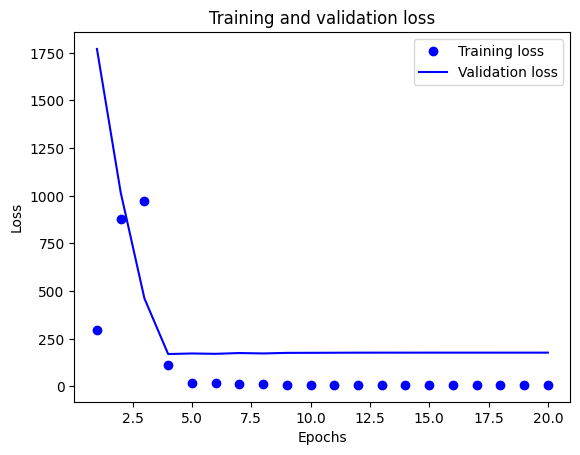

In [822]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

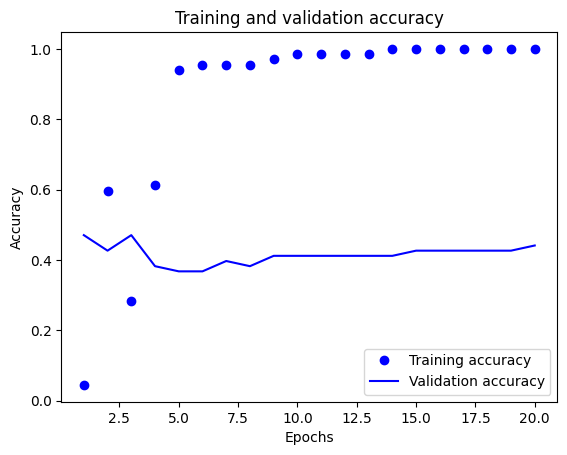

In [823]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()